In [185]:
import pandas as pd
import numpy as np
import mne
import matplotlib.pyplot as plt
from eeglib.helpers import Helper
import torch

In [2]:
file = pd.read_csv("../data/Focus.csv", skiprows=1, 
                    usecols=['EEG.Cz', 'EEG.Fz', 'EEG.Fp1', 'EEG.F7',
                            'EEG.F3', 'EEG.FC1', 'EEG.C3', 'EEG.FC5',
                            'EEG.FT9', 'EEG.T7', 'EEG.CP5', 'EEG.CP1',
                            'EEG.P3', 'EEG.P7', 'EEG.PO9', 'EEG.O1',
                            'EEG.Pz', 'EEG.Oz', 'EEG.O2', 'EEG.PO10',
                            'EEG.P8', 'EEG.P4', 'EEG.CP2', 'EEG.CP6',
                            'EEG.T8', 'EEG.FT10', 'EEG.FC6', 'EEG.C4',
                            'EEG.FC2', 'EEG.F4', 'EEG.F8', 'EEG.Fp2'])
df = pd.DataFrame(file)

In [145]:
def get_mean_electrode(slice, electrode):
    value = 0
    for i in range(slice.shape[0]):
        value += slice[i][electrode]
    return value / slice.shape[0]
        

In [189]:
def rescale_dataset(dataset, scale):
    scaled_set = torch.zeros([(int)(dataset.shape[0] / scale), dataset.shape[1]])
    for i in range(scaled_set.shape[0]):
        slice_of_ten = dataset[(i * scale):(i * scale + scale)]
        for j in range(scaled_set.shape[1]):
            scaled_set[i][j] = get_mean_electrode(slice_of_ten, j)
    return scaled_set

In [218]:
vanilla_data = df.to_numpy()
normalized_data = (vanilla_data - np.min(vanilla_data)) / (np.max(vanilla_data) - np.min(vanilla_data))
standardized_data = normalized_data - normalized_data.mean()
large_data = torch.Tensor(standardized_data)

train_set = rescale_dataset(large_data, 10)

In [219]:
def get_mean_values(dataset):
    mean_values = [0] * dataset.shape[0]
    for i in range(dataset.shape[0]):
        mean_values[i] = dataset[i].mean()
    return mean_values

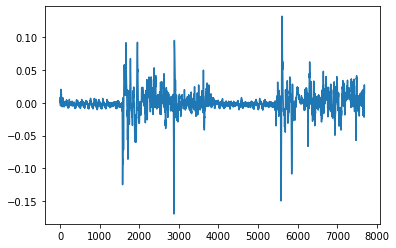

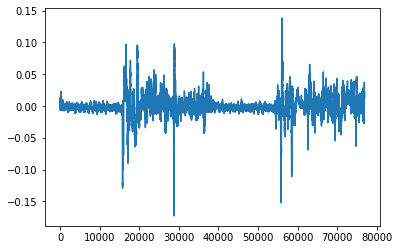

In [350]:
plt.plot(get_mean_values(train_set))
plt.show()
plt.plot(get_mean_values(large_data))
plt.show()

In [293]:
def labelize_set(train_set):
    result = list()
    for index, element in enumerate(train_set):
        if (index < 1500 or (index > 3900 and index < 5400)):
            result.append((element, 0))
        else:
            result.append((element, 1))
    return result
    
labelled_set = labelize_set(train_set)
focusedCount = 0
for signals, labels in labelled_set:
    if (labels == 0):
        focusedCount+=1
focusedCount / train_set.shape[0] * 100

39.01899557637263

In [294]:
import time
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [470]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()

        # Convolution layer
        self.conv1 = nn.Conv1d(1, 6, 5)
        self.conv2 = nn.Conv1d(6, 16, 5)
        self.max_pool = nn.MaxPool1d(2)
        # --------------------------------

        self.dropout = nn.Dropout(0.25)

        # Fully connected layer
        self.linear1 = nn.Linear(16 * 5, 120)
        self.linear2 = nn.Linear(120, 2)
        # --------------------------------

    def forward(self, x):
        x = x.view(64, 1, 32)
        # Convolution layer
        x = F.relu(self.conv1(x))
        x = self.max_pool(x)
        x = F.relu(self.conv2(x))
        x = self.max_pool(x)
        # -----------------------

        x = self.dropout(x)

        # Flatten filters
        x = x.view(-1, 16 * 5)

        # Fully connected layer
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        # -------------------------
        return x

In [471]:
network = NeuralNetwork()

LEARNING_RATE = 0.05
EPOCH = 10
BATCH_SIZE = 64

train_loader = torch.utils.data.DataLoader(labelled_set, batch_size=BATCH_SIZE, shuffle=True)
# # Load a loss calculator and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(network.parameters(), lr=LEARNING_RATE, momentum=0.9)

In [479]:
iteration = 0
start_time = time.time()

train_accuracies = np.zeros(EPOCH)
test_accuracies = np.zeros(EPOCH)

for iteration in range(EPOCH):
    average_loss = 0.0

    print("――――――――――――――――――――――――――――――――――――――――――――――――――")

    # Training
    total = 0
    success = 0
    for inputs, labels in tqdm(train_loader):
        optimizer.zero_grad()
        try:
            output = network.forward(inputs)
        except:
            continue
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        average_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        success += (predicted == labels.data).sum()
    train_accuracies[iteration] = 100.0 * success / total
    print(train_accuracies[iteration])
    # -------------------------------------------------------------------

    # # Testing
    # total = 0
    # success = 0
    # for inputs, labels in tqdm(test_loader):
    #     output = network.forward(inputs)
    #     _, predicted = torch.max(output.data, 1)
    #     total += labels.size(0)
    #     success += (predicted == labels.data).sum()
    # test_accuracies[iteration] = 100.0 * success / total
    # # -------------------------------------------------------------------

    # print(u"Epoch {}, average loss {}, train accuracy {}, test accuracy {}".format(
    #     iteration,
    #     average_loss / len(train_loader),
    #     train_accuracies[iteration],
    #     test_accuracies[iteration]
    # ))


――――――――――――――――――――――――――――――――――――――――――――――――――


100%|██████████| 121/121 [00:00<00:00, 609.31it/s]


39.04948043823242
――――――――――――――――――――――――――――――――――――――――――――――――――


100%|██████████| 121/121 [00:00<00:00, 739.90it/s]


39.04948043823242
――――――――――――――――――――――――――――――――――――――――――――――――――


100%|██████████| 121/121 [00:00<00:00, 768.99it/s]


39.01041793823242
――――――――――――――――――――――――――――――――――――――――――――――――――


100%|██████████| 121/121 [00:00<00:00, 689.88it/s]


39.01041793823242
――――――――――――――――――――――――――――――――――――――――――――――――――


100%|██████████| 121/121 [00:00<00:00, 637.36it/s]


39.0234375
――――――――――――――――――――――――――――――――――――――――――――――――――


100%|██████████| 121/121 [00:00<00:00, 680.97it/s]


39.04948043823242
――――――――――――――――――――――――――――――――――――――――――――――――――


100%|██████████| 121/121 [00:00<00:00, 667.88it/s]


39.04948043823242
――――――――――――――――――――――――――――――――――――――――――――――――――


100%|██████████| 121/121 [00:00<00:00, 680.13it/s]


38.984375
――――――――――――――――――――――――――――――――――――――――――――――――――


100%|██████████| 121/121 [00:00<00:00, 635.46it/s]


38.99739456176758
――――――――――――――――――――――――――――――――――――――――――――――――――


100%|██████████| 121/121 [00:00<00:00, 683.66it/s]

39.0234375
